## Preparation

### Libraries

In [22]:
try:
    import secmlt
    import sklearn
    import matplotlib
    import foolbox

except ImportError:
    print("Installing the dependancies")
    %pip install git+https://github.com/pralab/secml-torch
    %pip install scikit-learn
    %pip install matplotlib
    %pip install foolbox

from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from secmlt.models.pytorch.base_pytorch_trainer import BasePyTorchTrainer
from secmlt.metrics.classification import Accuracy
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
import torch

from secmlt.trackers.trackers import Tracker
from secmlt.trackers.trackers import MULTI_SCALAR

from secmlt.adv.evasion.pgd import PGD
from secmlt.adv.evasion.fmn import FMN
from secmlt.adv.backends import Backends
from secmlt.adv.evasion.perturbation_models import LpPerturbationModels

### Points generation

We create some data using another library called `scikit-learn`.

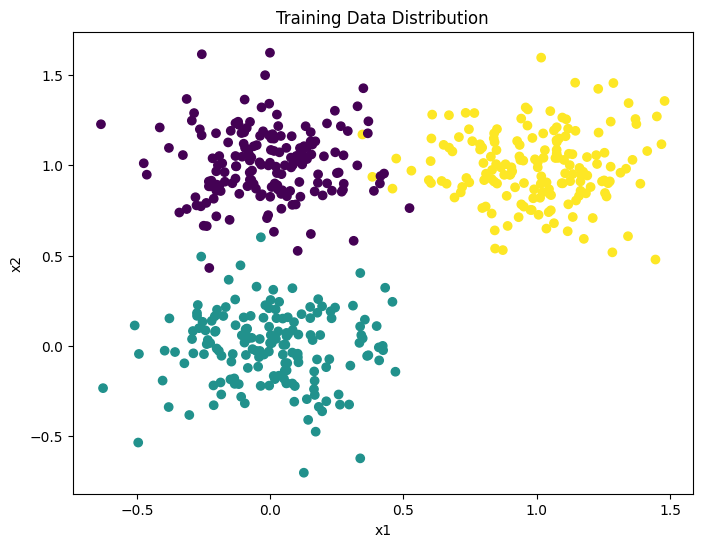

Data shape: torch.Size([500, 2])
Labels shape: torch.Size([500])


In [23]:
def plot_data(X, y, title="Data Distribution"):
    """
    Plot the data points colored by their classes.
    
    Args:
        X: Input features as tensor or numpy array
        y: Labels as tensor or numpy array
        title: Plot title
    """
    # Convert tensors to numpy if needed
    if torch.is_tensor(X):
        X = X.detach().numpy()
    if torch.is_tensor(y):
        y = y.detach().numpy()
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.show()

X_train, y_train = make_blobs(n_samples=500, 
                  centers=[(0, 1), (0, 0), (1, 1)],
                  n_features=2,
                  cluster_std=0.2,
                  random_state=999)

# Visualize the data
plot_data(X_train, y_train, title="Training Data Distribution")

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

print(f"Data shape: {X_train.shape}")
print(f"Labels shape: {y_train.shape}")

We do the same to create test data, that will be used to compute the accuracy of our model.

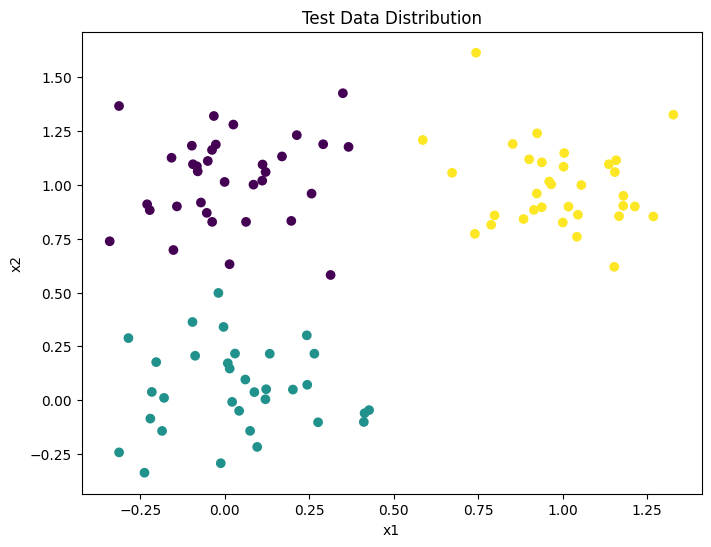

Data shape: torch.Size([100, 2])
Labels shape: torch.Size([100])


In [24]:
X_test, y_test = make_blobs(n_samples=100, 
                  centers=[(0, 1), (0, 0), (1, 1)],
                  n_features=2,
                  cluster_std=0.2,
                  random_state=999)

plot_data(X_test, y_test, title="Test Data Distribution")

# Convert to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

print(f"Data shape: {X_test.shape}")
print(f"Labels shape: {y_test.shape}")

We also already converted those samples in torch Tensors, which are the basic and main Pytorch objects.
Observations are defined as FloatTensors, while labels are LongTensors.

We can now create a main concept in Pytorch, which is the DataLoader.
A DataLoader dispatches data in batches, ready to be used to train models.

In [25]:
tr_dataloader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=False)
ts_dataloader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

print(f"Number of batches: {len(tr_dataloader)}")

Number of batches: 16


### Neural Network
Creating a simple network with only dense layers and ReLU activation functions.

In [26]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(2, 16)  # Input layer to hidden layer
        self.fc2 = torch.nn.Linear(16, 16) # Hidden layer to hidden layer
        self.fc3 = torch.nn.Linear(16, 3)  # Hidden layer to output layer
        self.relu = torch.nn.ReLU()         # ReLU activation function

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Apply first layer and ReLU
        x = self.relu(self.fc2(x))  # Apply second layer and ReLU
        x = self.fc3(x)             # Apply output layer (no activation here)

        return x

model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
trainer = BasePyTorchTrainer(optimizer=optimizer, loss=criterion, epochs=50)
secmlt_model = BasePytorchClassifier(model, trainer=trainer)
secmlt_model.train(tr_dataloader)

print(model)
print("Number of parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Net(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=3, bias=True)
  (relu): ReLU()
)
Number of parameters: 371


Plotting

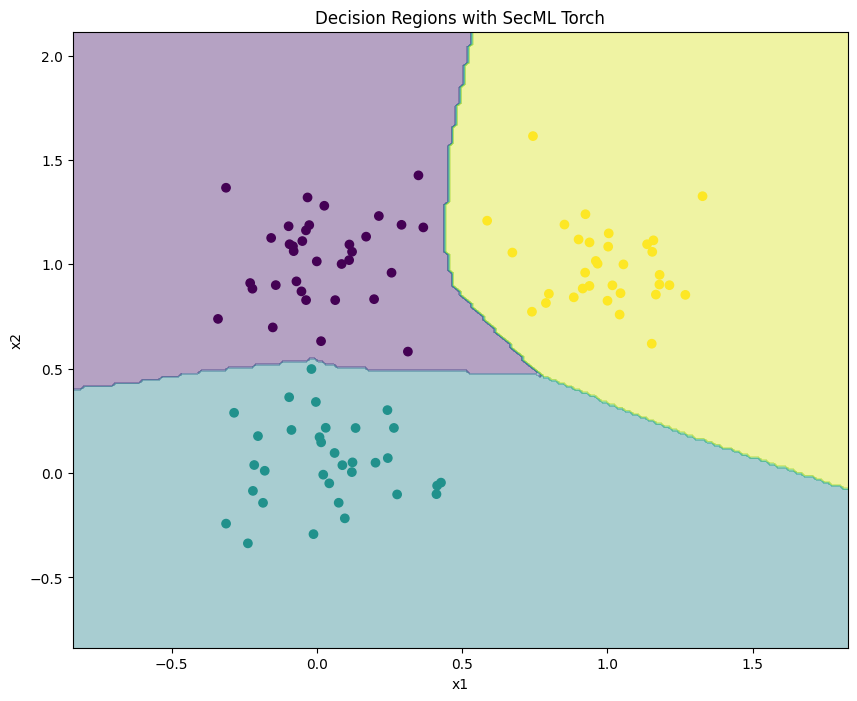

In [27]:
def plot_decision_regions(model, X, y, title="Decision Regions"):
    """
    Plot decision regions for a PyTorch model.
    
    Args:
        model: PyTorch model (must be in eval mode)
        X: Input features as tensor
        y: Labels as tensor
        title: Plot title
    """
    # Convert tensors to numpy for plotting
    X_np = X.detach().numpy()
    y_np = y.detach().numpy()
    
    # Create a mesh grid
    x_min, x_max = X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5
    y_min, y_max = X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                        np.linspace(y_min, y_max, 200))
    
    # Get predictions for each point in the mesh
    X_mesh = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    
    with torch.no_grad():
        model.eval()
        Z = model(X_mesh)
        Z = torch.argmax(Z, dim=1)

    Z = Z.numpy().reshape(xx.shape)
    
    # Plot decision regions
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    # Plot data points
    scatter = plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, 
                         cmap='viridis')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.show()

plot_decision_regions(secmlt_model.model, X_test, y_test, title="Decision Regions with SecML Torch")

## Minimum-norm

In [28]:
class Sample2DTracker(Tracker):
    def __init__(self) -> None:
        """Create adversarial 2D sample tracker."""
        super().__init__("Sample", MULTI_SCALAR)
        self.tracked = []

    def track(
        self,
        iteration: int,
        loss: torch.Tensor,
        scores: torch.Tensor,
        x_adv: torch.Tensor,
        delta: torch.Tensor,
        grad: torch.Tensor,
    ) -> None:
        self.tracked.append(x_adv)

def secmlt_plot_attack_path(model, X, y, x_init, x_advs, epsilon, title="Attack Path on Decision Regions", norm="L2"):
    """
    Plots decision regions, the initial sample as a green large circle, the attack path, and the last sample as a red cross. Optionally plots the norm ball.

    Args:
        model: Trained PyTorch model.
        X: Input features (torch.Tensor) for decision region background.
        y: Labels (torch.Tensor) for coloring points.
        x_init: Initial sample (torch.Tensor, shape [2] or [1,2]).
        deltas: Attack deltas (torch.Tensor, shape [2, N] or [N, 2]).
        epsilon: (Optional) Radius of the norm ball to plot.
        title: Plot title.
        norm: Type of norm to use ('L0', 'L1', 'L2', or 'LINF')
    """

    x_advs = x_advs.T.squeeze().numpy()
    # Prepare mesh grid for decision regions
    X_np = X.detach().numpy()
    y_np = y.detach().numpy()
    x_min, x_max = X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5
    y_min, y_max = X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    X_mesh = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

    with torch.no_grad():
        Z = model(X_mesh)
        Z = torch.argmax(Z, dim=1)
    Z = Z.numpy().reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='viridis', edgecolor='k', s=30, alpha=0.7)

    # Initial sample as a green large circle
    x_init_np = x_init.detach().cpu().numpy()

    if x_init_np.ndim == 2:
        x_init_np = x_init_np[0]

    # Plot norm ball if epsilon is provided
    if epsilon is not None:
        if norm.upper() == "L2":
            circle = plt.Circle((x_init_np[0], x_init_np[1]), epsilon, color='red', fill=False, linestyle='--', linewidth=2, label=f'L2 Ball (ε={epsilon})')
            plt.gca().add_patch(circle)
        elif norm.upper() == "L1":
            # Create diamond (L1 ball)
            diamond = np.array([[0,1], [1,0], [0,-1], [-1,0], [0,1]]) * epsilon
            diamond = diamond + x_init_np
            plt.plot(diamond[:,0], diamond[:,1], 'r--', linewidth=2, label=f'L1 Ball (ε={epsilon})')
        elif norm.upper() == "LINF":
            # Create square (L∞ ball)
            square = np.array([[-1,-1], [1,-1], [1,1], [-1,1], [-1,-1]]) * epsilon
            square = square + x_init_np
            plt.plot(square[:,0], square[:,1], 'r--', linewidth=2, label=f'L∞ Ball (ε={epsilon})')
    
    # Concatenate the initial point to the attack path
    path = np.vstack([x_init_np, x_advs])
    plt.plot(path[:, 0], path[:, 1], color='black', linewidth=2, marker='o', markersize=4, label='Attack Path')
    # Last sample as a red cross
    last_sample = path[-1]
    plt.scatter(path[0,0], path[0,1], marker='o', color='green', s=250, edgecolor='black', linewidths=2, label='Initial Sample', zorder = 2)
    plt.scatter(last_sample[0], last_sample[1], marker='x', color='red', s=200, linewidths=4, label='Final Sample', zorder = 2)
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Un-targeted

In [38]:
def security_evaluation_min(model, dataloader, epsilons, iterations, stepsize):
    sec_eval_data = []

    for e in epsilons:
        path_tracker = Sample2DTracker()
        
        fmn_attack = FMN(
            perturbation_model=LpPerturbationModels.L2,
            num_steps=iterations,
            step_size=stepsize,
            y_target=None,
            lb=-2,
            ub=2,
            backend = Backends.NATIVE,
            trackers=[path_tracker]
        )

        adv_dataloader = fmn_attack(model, dataloader)
        x_adv = adv_dataloader.dataset[0][0]
        y_pred = model(x_adv).argmax(dim=-1)
        print(f"Accuracy after attack:{Accuracy()(model, adv_dataloader) * 100:.2f}")

        print("Predicted label:", y_pred.item(), "\nReal label:", y_test[0].item())

        secmlt_plot_attack_path(model.model, X_test, y_test, X_test[0,:], path_tracker.get(), None, title="Attack Path on Decision Regions")

        robust_accuracy = Accuracy()(model, adv_dataloader)
        sec_eval_data.append(robust_accuracy)
        
    return sec_eval_data

In [39]:
alpha = 1e-2
num_iter = 500
epsilons = [0.1, 0.3, 0.5, 0.7, 0.9]
single_sample_loader = DataLoader(TensorDataset(X_test[0:1,:], y_test[0:1]), batch_size=1, shuffle=False)

sec_eval = security_evaluation_min(model, single_sample_loader, epsilons=epsilons, iterations=num_iter, stepsize=alpha)

plt.plot(epsilons, sec_eval, label='SecEval')
plt.xlabel('Epsilon')
plt.ylabel('Robust Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

AttributeError: 'Net' object has no attribute 'decision_function'

Security evaluation

In [ ]:
for e in epsilons:
    plt.plot(epsilons, model, label='MinSecEval')
    plt.xlabel('Epsilon')
    plt.ylabel('Robust Accuracy')
    plt.ylim(0, 1)
    plt.legend()

### Targeted

## Maximum-confidence

### Untargeted

Predicted label: 0 
Real label: 2


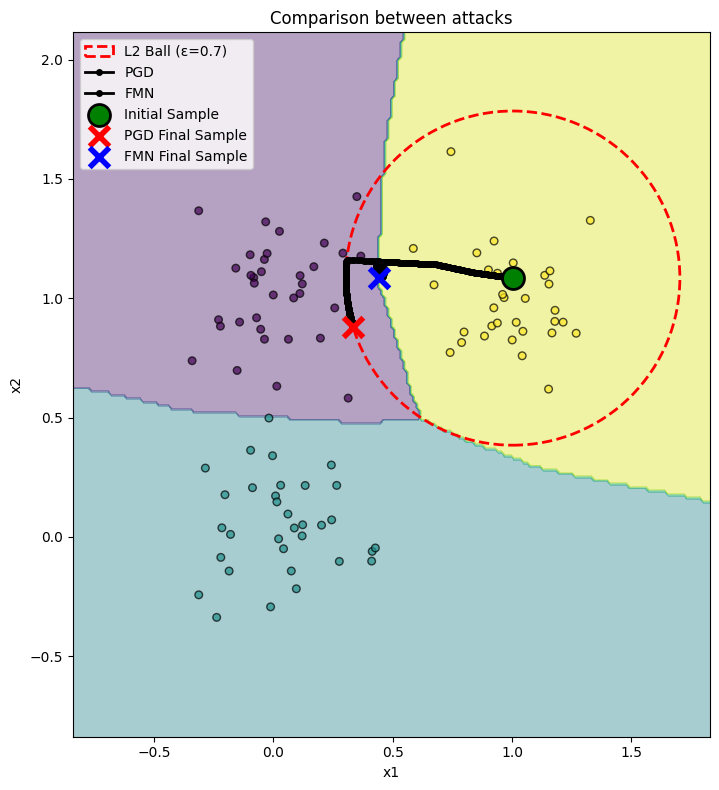

In [ ]:
def security_evaluation_max(model, dataloader, epsilons, iterations, stepsize):
    sec_eval_data = []

    for e in epsilons:
        path_tracker = Sample2DTracker()
        
        fmn_attack = PGD(
            perturbation_model=LpPerturbationModels.L2,
            num_steps=iterations,
            step_size=stepsize,
            y_target=None,
            epsilon=e,
            lb=-2,
            ub=2,
            backend = Backends.NATIVE,
            trackers=[path_tracker]
        )

        adv_dataloader = fmn_attack(model, dataloader)
        x_adv = adv_dataloader.dataset[0][0]
        y_pred = model(x_adv).argmax(dim=-1)
        print(f"For epsilon = {e} -> accuracy after attack:{Accuracy()(model, adv_dataloader) * 100:.2f}")

        print("Predicted label:", y_pred.item(), "\nReal label:", y_test[0].item())

        secmlt_plot_attack_path(model.model, X_test, y_test, X_test[0,:], path_tracker.get(), None, title="Attack Path on Decision Regions")

        robust_accuracy = Accuracy()(model, adv_dataloader)
        sec_eval_data.append(robust_accuracy)
        
    return sec_eval_data

In [ ]:
for e in epsilons:
    plt.plot(epsilons, model, label='MaxSecEval')
    plt.xlabel('Epsilon')
    plt.ylabel('Robust Accuracy')
    plt.ylim(0, 1)
    plt.legend()

### Targeted